# Installation 

Libraries used:

  *   [pyannote](https://github.com/pyannote/pyannote-audio) (require restarting kernel after finish installing)
  *   [speechbrain](https://github.com/speechbrain/speechbrain) (for Embedding)

In [ ]:
# install pyannote(currently 2.0)
!pip install -q pyannote.audio
# !pip install -q https://github.com/pyannote/pyannote-audio/archive/develop.zip 

# for speechbrain
# !pip install -q speechbrain

In [ ]:
# install pyannote 1.0 (commits before big change of 2.0)
# !pip install https://github.com/pyannote/pyannote-audio/archive/871272c7c9c2ffacc4570cea9e487658ed145e70.zip

# for speechbrain
# !pip install -q speechbrain

In [ ]:
# # install pyannote 2.0 on Colab without dependencies
# # for speechbrain
# !pip install -qq torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 torchtext==0.12.0
# !pip install -qq speechbrain==0.5.12

# # pyannote.audio
# !pip install -qq pyannote.audio

# # for visualization purposes
# !pip install -qq moviepy ipython==7.34.0

# Loading Model

In [ ]:
# # Pretrained pipeline
# from pyannote.audio import Pipeline
# pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization")

## From checkpoints

In [ ]:
# !unzip checkpoints.zip

In [ ]:
from pyannote.audio import Model
from copy import deepcopy

pretrained = Model.from_pretrained("pyannote/segmentation")
finetuned = deepcopy(pretrained)
finetuned = finetuned.load_from_checkpoint("checkpoints/epoch=19-step=6780.ckpt")

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


## From h5

In [ ]:
import torch
# pipeline = torch.load("pipeline.h5")
finetuned = torch.load("seg.h5")

# Add finetuned segmentation model to the speaker diarization pipeline
- [pretrained config here](https://huggingface.co/pyannote/speaker-diarization/blob/main/config.yaml)
- hparams: [segmentation](https://github.com/pyannote/pyannote-audio/blob/develop/pyannote/audio/pipelines/segmentation.py#L50) [clustering](https://github.com/pyannote/pyannote-audio/blob/develop/pyannote/audio/pipelines/clustering.py) [diarization](https://github.com/pyannote/pyannote-audio/blob/develop/pyannote/audio/pipelines/speaker_diarization.py#L56)

### pyannote 1.0

In [ ]:
# Add finetuned segmentation model to the speaker diarization pipeline
from pyannote.audio.pipelines import SpeakerDiarization
pipeline = SpeakerDiarization(
    segmentation=finetuned,
    # embedding="speechbrain/spkrec-ecapa-voxceleb",
    # embedding="pyannote/embedding",
    )
initial_params = {
    # onset/offset activation thresholds
    "onset": 0.810,
    "offset": 0.481,

    # remove speech regions shorter than that many seconds
    "min_duration_on": 0.055,
    # "min_duration_on": 0.255,

    # fill non-speech regions shorter than that many seconds
    "min_duration_off": 0.098,

    "min_activity": 6.073,
    "stitch_threshold": 0.040,
    
    # "clustering": {"method": "average", "threshold": 0.595},}
    "clustering": {"method": "average", "threshold": 0.395},}
pipeline.instantiate(initial_params)

### pyannote 2.0

In [ ]:
# Add finetuned segmentation model to the speaker diarization pipeline
from pyannote.audio.pipelines import SpeakerDiarization
pipeline = SpeakerDiarization(
    segmentation=finetuned,
    embedding="speechbrain/spkrec-ecapa-voxceleb",
    )
initial_params = {
                "segmentation_onset": 0.58,
                "clustering": {
                    "single_cluster_detection": {
                        "quantile": 0.05,
                        "threshold": 0.15,
                    },
                    "covariance_type": "diag",
                    "threshold": 0.35,
                },
}
pipeline.instantiate(initial_params)

# Preparation for Evaluation

In [ ]:
import os
from pyannote.core import notebook, Segment
from pyannote.database.util import load_rttm
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate, DiarizationPurity, DiarizationCoverage

# Evaluation metrics
def eval(metrics, groundtruth, result):
  for metric in metrics:
    metric(groundtruth,result)

  df = pd.concat([metric.report() for metric in metrics], axis=1)
  df = df.loc[:,[
    ('diarization error rate', '%'),
    ('false alarm',"%"),
    ('missed detection','%'),
    ('confusion', '%'),
    ('purity', '%'),
    ('coverage', '%'),
    ]]
  df.index.name = None
  df.columns = ['diarization error rate',
    'false alarm',
    'missed detection',
    'confusion',
    'purity',
    'coverage']
  return df

In [ ]:
import matplotlib.pyplot as plt

# Visualization
def repr_annotation(annotation):
    figsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (notebook.width, 2)
    fig, ax = plt.subplots()
    notebook.plot_annotation(annotation, ax=ax)
    # plt.close(fig)
    # plt.rcParams["figure.figsize"] = figsize

In [ ]:
# Save Result as RTTM
def save_rttm(filename, annotation):
  with open(filename, 'w') as file:
    annotation.write_rttm(file)

# Evaluation

[Reference here](https://pyannote.github.io/pyannote-metrics/reference.html)

## With particular test case

In [ ]:
test_path = "_path_to_wav_"
rttm_path = "_path_to_rttm_"

'Parliament_1m'

In [ ]:
# Without rttm as groundtruth
result = pipeline(test_path)
notebook.reset()
result

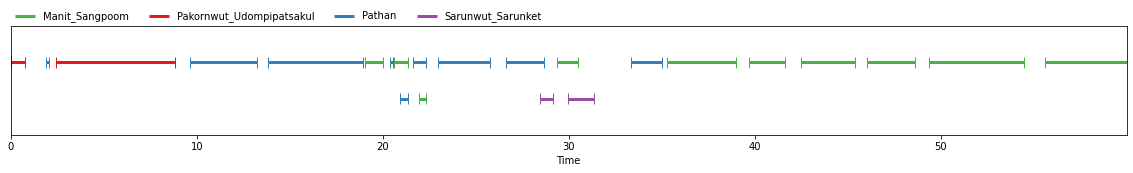

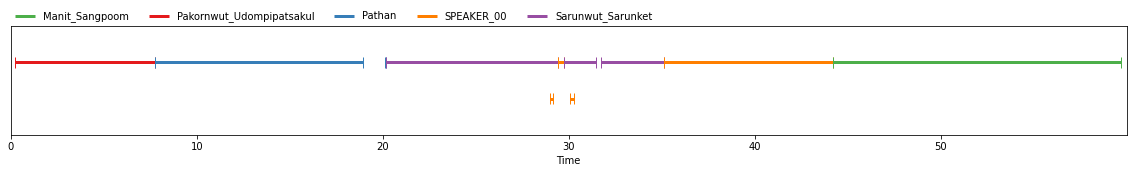

In [ ]:
# With rttm as groundtruth
result = pipeline(test_path)
loaded_groundtruth = load_rttm(rttm_path)
_, groundtruth = loaded_groundtruth.popitem()

# Mapping speaker
mapping = DiarizationErrorRate().optimal_mapping(groundtruth, result)
result = result.rename_labels(mapping=mapping)

notebook.reset()
# notebook.crop = Segment(60, 100)
repr_annotation(groundtruth)
repr_annotation(result)

In [ ]:
metrics = [DiarizationErrorRate(), DiarizationPurity(), DiarizationCoverage()]
eval(metrics, groundtruth, result)

,diarization error rate,false alarm,missed detection,confusion,purity,coverage
Parliament_10m,8.91,1.48,6.59,0.84,91.78,91.78
TOTAL,8.91,1.48,6.59,0.84,91.78,91.78


In [ ]:
# save_rttm(filename="ex.rttm",annotation=result)

## With every test dataset
https://drive.google.com/drive/folders/1N-hi2sl-zqJjnY_1cHpox2a-2SUO4x8s?usp=sharing

In [ ]:
# Query Test File
path = "tests/"
TEST_FILE = []
for subpath in os.listdir(path):
  dic = {"uri": subpath}
  for file in os.listdir(path+subpath):
    if file.endswith(".wav"): dic["audio"] = path+subpath+"/"+file
    elif file.endswith(".rttm"): dic["rttm"] = path+subpath+"/"+file
  TEST_FILE.append(dic)
TEST_FILE

[{'audio': 'tests/Parliament_10m/Parliament_10m.wav',
  'rttm': 'tests/Parliament_10m/Parliament_10m.rttm',
  'uri': 'Parliament_10m'},
 {'audio': 'tests/Parliament_Part_2/Parliament_Part_2.wav',
  'rttm': 'tests/Parliament_Part_2/Parliament_Part_2.rttm',
  'uri': 'Parliament_Part_2'},
 {'audio': 'tests/Suwipa1/Suwipa1.wav',
  'rttm': 'tests/Suwipa1/Suwipa1.rttm',
  'uri': 'Suwipa1'},
 {'audio': 'tests/Parliament_1m/Parliament_1m.wav',
  'rttm': 'tests/Parliament_1m/Parliament_1m.rttm',
  'uri': 'Parliament_1m'},
 {'audio': 'tests/Parliament_Part_1/Parliament_Part_1.wav',
  'rttm': 'tests/Parliament_Part_1/Parliament_Part_1.rttm',
  'uri': 'Parliament_Part_1'}]

In [ ]:
# Load rttm as Annotation
results={}
groundtruths={}
metrics = [DiarizationErrorRate(), DiarizationPurity(), DiarizationCoverage()]

for test in TEST_FILE:
  print(test["uri"])
  result = pipeline(test)
  loaded_groundtruth = load_rttm(test["rttm"])
  _, groundtruth = loaded_groundtruth.popitem()

  # Mapping speaker
  mapping = DiarizationErrorRate().optimal_mapping(groundtruth, result)
  result = result.rename_labels(mapping=mapping)

  groundtruths[test["uri"]] = groundtruth
  results[test["uri"]] = result

  df_eval = eval(metrics, groundtruth, result)

In [ ]:
# Evaluation Metrics 20ep lr=1e-4 batch_size=256
sorter = ["Parliament_1m","Parliament_10m",'Parliament_Part_1',"Parliament_Part_2","Suwipa1"]
df_eval.loc[sorter]

,diarization error rate,false alarm,missed detection,confusion,purity,coverage
Parliament_1m,33.44,23.03,5.66,4.76,90.95,95.13
Parliament_10m,10.71,1.48,6.60,2.63,91.74,90.00
Parliament_Part_1,7.25,4.96,0.93,1.35,98.11,98.11
Parliament_Part_2,5.95,2.99,1.03,1.93,98.63,96.92
Suwipa1,25.40,8.11,3.91,13.38,83.98,100.00


In [ ]:
# Evaluation Metrics 10ep lr=1e-4 batch_size=256
sorter = ["Parliament_1m","Parliament_10m",'Parliament_Part_1',"Parliament_Part_2","Suwipa1"]
df_eval.loc[sorter]

,diarization error rate,false alarm,missed detection,confusion,purity,coverage
Parliament_1m,44.90,19.60,4.63,20.67,75.49,93.67
Parliament_10m,11.39,0.89,7.91,2.59,91.66,89.94
Parliament_Part_1,5.42,2.65,1.45,1.32,98.08,98.08
Parliament_Part_2,5.00,1.37,1.42,2.21,98.62,96.64
Suwipa1,22.23,4.74,7.02,10.47,86.52,100.00


In [ ]:
# Evaluation Metrics 10ep thr=4.445
sorter = ["Parliament_1m","Parliament_10m",'Parliament_Part_1',"Parliament_Part_2","Suwipa1"]
df_eval.loc[sorter]

,diarization error rate,false alarm,missed detection,confusion,purity,coverage
Parliament_1m,49.32,25.89,2.86,20.57,73.10,90.29
Parliament_10m,9.51,1.72,5.98,1.81,90.38,90.38
Parliament_Part_1,6.43,4.52,0.54,1.38,98.12,98.12
Parliament_Part_2,3.53,2.30,0.90,0.33,98.43,98.43
Suwipa1,30.41,10.24,5.27,14.90,82.44,100.00


Suwipa1


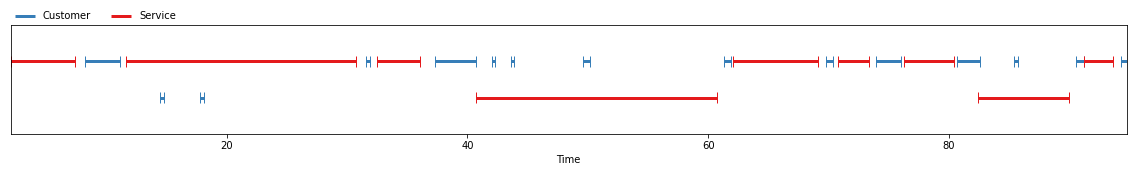

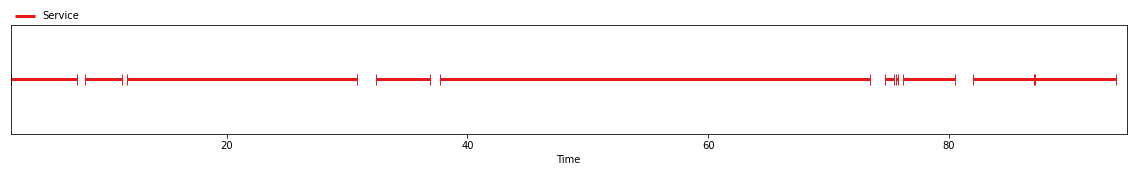

In [ ]:
# Visualization
uri = TEST_FILE[2]["uri"]
print(uri)
notebook.reset()
# start=0
# notebook.crop = Segment(start, start+60)
# start+=60
repr_annotation(groundtruths[uri])
repr_annotation(results[uri])

# Tensorboard

In [ ]:
# !unzip "lightning_logs.zip"

Archive:  /content/lightning_logs_20ep.zip
   creating: lightning_logs/version_0/
  inflating: lightning_logs/version_0/events.out.tfevents.1658213091.3c2766ef5449.384.0  
   creating: lightning_logs/version_0/checkpoints/
  inflating: lightning_logs/version_0/checkpoints/epoch=19-step=6780.ckpt  
  inflating: lightning_logs/version_0/hparams.yaml  


In [ ]:
# # for colab
# from google.colab import output
# output.serve_kernel_port_as_window(6006)

<IPython.core.display.Javascript object>

In [ ]:
!tensorboard --logdir=lightning_logs


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
# TODO: edit tensorboard step (using tensorflow v1)
# https://stackoverflow.com/questions/54987749/how-to-edit-a-saved-tensorboard-summary/55061404#55061404

# import tensorflow as tf
# summary_writer = tf.summary.create_file_writer ("test")

# for event in tf.compat.v1.train.summary_iterator ("/content/lightning_logs_test/version_1/events.out.tfevents.1658213091.3c2766ef5449.384.0"):
#     if (event.step < 1000000):
#         shifted_step = event.step + 1000000
#         for value in event.summary.value:
#             print(value.tag)
#             if (value.HasField('simple_value')):
#                 print(value.simple_value)
#             break;
#                 summary = tf.Summary(value=[
#                   tf.Summary.Value(tag='{}'.format(value.tag),simple_value=value.simple_value), 
#                 ])

#         summary_writer.add_summary(summary, shifted_step)
#         summary_writer.flush()